In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import pickle

df = pd.read_feather("../data/processed/train_data_processed.feather")

X = df.drop(columns=['TLJYWBE'])
y = df['TLJYWBE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(454091, 221)

# Model selection

In [4]:
"""try different models"""
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Elastic Net Regression': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'LGBM': LGBMRegressor(n_estimators=100, verbose=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100),
}

results = {}

# Train and evaluate each model and perform cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    # avg_rmse = np.mean(np.sqrt(-scores))
    print(f'{name} - Average R2 from CV: {np.mean(scores)}')

Linear Regression - Average R2 from CV: -339553477535.3271
Ridge Regression - Average R2 from CV: 0.24004605072845253
Lasso Regression - Average R2 from CV: 0.11655238868645001
Elastic Net Regression - Average R2 from CV: 0.16075801136325207
Decision Tree - Average R2 from CV: 0.3100898616087099
LGBM - Average R2 from CV: 0.4728557990488933
XGBoost - Average R2 from CV: 0.4892071201848246


# Parameter tuning & Cross validation

In [8]:
# Define the model
xgb_model = xgb.XGBRegressor()

# Set up hyperparameters to tune
param_grid = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='r2', cv=2, verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_
print(f"Best params: {grid_search.best_params_}")
predictions = best_xgb_model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions)
print(f"Root Mean Squared Error: {rmse}")
r2 = r2_score(y_test, predictions)
print(f"R^2 Error: {r2}")

# Save the model to disk
filename = 'finalized_xgb_model.pkl'
pickle.dump(best_xgb_model, open(filename, 'wb'))

# Example of loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
# Test loaded model
test_predictions = loaded_model.predict(X_test)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Root Mean Squared Error: 1.394575834810144
R^2 Error: 0.47161744696124086


# Training the final model

In [3]:
# Setting up the data in DMatrix format, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Initial model parameters
params = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror'  
}

num_boost_round = 999

# Using early stopping to find the optimal number of boosting rounds
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
# Print the best RMSE and the best iteration
print("Best RMSE: {:.2f} with {} rounds".format(
    model.best_score,
    model.best_iteration + 1))

# Save the model to disk
model.save_model('../model/finalized_model.json')

# Create a booster object
loaded_model = xgb.Booster()

# Load the model from the file 
loaded_model.load_model('../model/finalized_model.json') 
predictions = loaded_model.predict(dtest)
print('done')

[0]	Test-rmse:0.97213
[1]	Test-rmse:0.94347
[2]	Test-rmse:0.91935
[3]	Test-rmse:0.89877
[4]	Test-rmse:0.88092
[5]	Test-rmse:0.86591
[6]	Test-rmse:0.85309
[7]	Test-rmse:0.84210
[8]	Test-rmse:0.83239
[9]	Test-rmse:0.82441
[10]	Test-rmse:0.81748
[11]	Test-rmse:0.81147
[12]	Test-rmse:0.80591
[13]	Test-rmse:0.80116
[14]	Test-rmse:0.79704
[15]	Test-rmse:0.79297
[16]	Test-rmse:0.78964
[17]	Test-rmse:0.78675
[18]	Test-rmse:0.78359
[19]	Test-rmse:0.78101
[20]	Test-rmse:0.77841
[21]	Test-rmse:0.77628
[22]	Test-rmse:0.77413
[23]	Test-rmse:0.77206
[24]	Test-rmse:0.77001
[25]	Test-rmse:0.76809
[26]	Test-rmse:0.76627
[27]	Test-rmse:0.76476
[28]	Test-rmse:0.76295
[29]	Test-rmse:0.76141
[30]	Test-rmse:0.75999
[31]	Test-rmse:0.75883
[32]	Test-rmse:0.75773
[33]	Test-rmse:0.75644
[34]	Test-rmse:0.75494
[35]	Test-rmse:0.75416
[36]	Test-rmse:0.75318
[37]	Test-rmse:0.75210
[38]	Test-rmse:0.75116
[39]	Test-rmse:0.75036
[40]	Test-rmse:0.74951
[41]	Test-rmse:0.74870
[42]	Test-rmse:0.74765
[43]	Test-rmse:0.7469

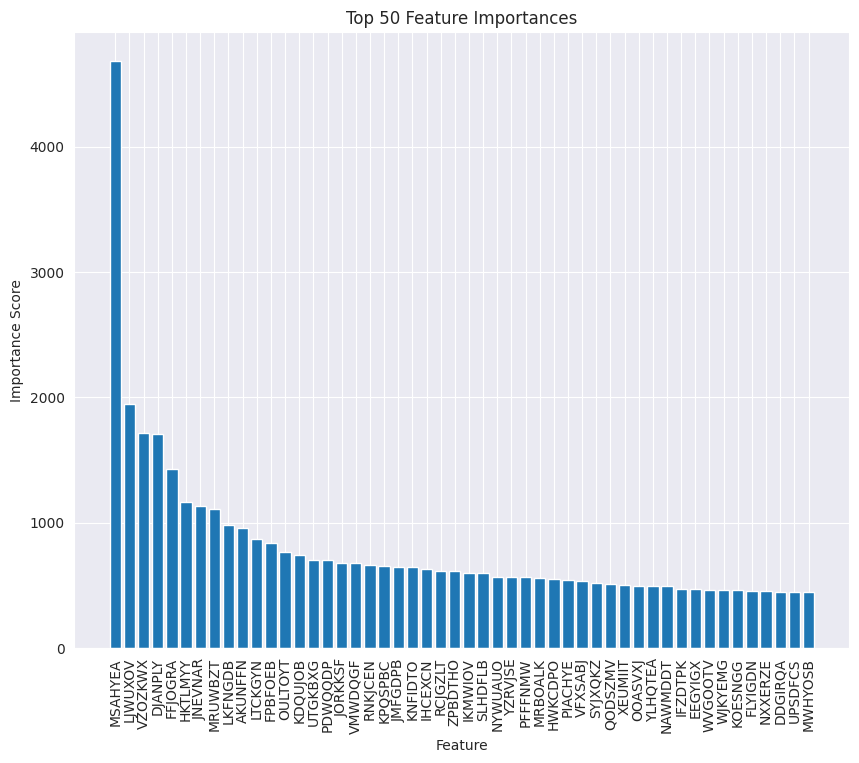

In [9]:
from matplotlib import pyplot as plt
import operator

importance = model.get_score()
sorted_importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)[:50]

# Plot feature importance for top 50 features
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_importance)), [v[1] for v in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [v[0] for v in sorted_importance], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 50 Feature Importances')
plt.show()